# Using ParamFitter

Once a sample has been created, one may want to fit the parameters to match some observed data. This is facilitated by `ParamFitter` class. It uses `scipy`'s `least_square` function to fit. However, internally it takes care of converting between the `ParamDict` and `numpy` vector as well as only varying the non-fixed parameters.  

In [1]:
import pymecht as pmt
import numpy as np
from matplotlib import pyplot as plt

pmt.ParamFitter?

Init signature: pmt.ParamFitter(sim_func, output, params=None)
Docstring:     
A class to fit parameters of a simulation function to a given output

Parameters
----------
sim_func : function
    A function that takes in a dictionary of parameters and returns a numpy array of the same shape as the output

output : numpy array
    A numpy array of the same shape as the output of the sim_func to be fitted

params : ParamDict
    A dictionary of parameters to be varied
File:           /usr/local/lib/python3.9/site-packages/pymecht/ParamFitter.py
Type:           type
Subclasses:     


As we can see, creating an instance of `ParamFitter` requires three main things: 

1) a Python function that takes in parameters, perform the simulation and returns the modeled output
2) the observed output array
3) parameters

The ability to provide a function for the simulation provides flexibility in how the problem can be setup. In a simple setting it could be just performing a single simulation of a single sample. In more complex scenarios, one can perform multiple simulations of multiple samples and combine their output, potentially through a weighting function. We can start with a simple case

## Simple fitting

Assume a uniaxial extension experiment, which was force controlled. That is the applied stress was varied linearly and the stretch was observed.

In [2]:
mat = pmt.MatModel('yeoh')
sample = pmt.UniaxialExtension(mat, force_measure='cauchy')
params = sample.parameters
print(sample, params)

applied_stress = np.linspace(0,50,10)
observed_stretch = np.array([1., 1.09144422, 1.17650268, 1.25077441, 1.31313774, 1.36499585,
 1.40850493, 1.4455964, 1.4777529,  1.50606163])

def simulate(param_vary):
    mod_stretch = sample.force_controlled(applied_stress,param_vary) #make sure that the argument param_vary is used
    return mod_stretch
    

An object of type UniaxialExtensionwith stretch as input, cauchy as output, and the following material
Material model with 1 component:
Component1: YEOH
 ------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
L0                1.00        No          1.00e-04    1.00e+03    
A0                1.00        No          1.00e-04    1.00e+03    
c1_0              1.00        No          1.00e-04    1.00e+02    
c2_0              1.00        No          0.00        1.00e+02    
c3_0              1.00        No          0.00        1.00e+02    
c4_0              0.00        No          0.00        1.00e+02    
------------------------------------------------------------------



For stress and stretch, the length and cross-sectional area would not be relevant. Thus, it is best to fix them. We will also fix c4_0. Also, note that when creating the instance of `ParamFitter` it will call the simulation function once to check that it returns an array of same size as the observations. Otherwise, it will raise an error.

In [3]:
params.fix('L0')
params.fix('A0')
params.fix('c4_0')
try:
    param_fitter = pmt.ParamFitter(simulate,observed_stretch[:-1],params)
except ValueError as e:
    print("Error occured", e)

param_fitter = pmt.ParamFitter(simulate,observed_stretch,params)

Error occured ('Output and simulation results are of different shape', (10,), (9,))
Parameter fitting instance created with the following settings
------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
L0                1.00        Yes         -           -           
A0                1.00        Yes         -           -           
c1_0              1.00        No          1.00e-04    1.00e+02    
c2_0              1.00        No          0.00        1.00e+02    
c3_0              1.00        No          0.00        1.00e+02    
c4_0              0.00        Yes         -           -           
------------------------------------------------------------------

3 parameters will be fitted.


Once the `ParamFitter` instance has been created successfully, one can just do `.fit()` to perform the fitting.

In [4]:
param_fitter.fit()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.5172e-01                                    2.56e+01    
       1              2         1.6712e-01      2.85e-01       1.73e+00       4.88e+00    
       2              3         7.2197e-02      9.49e-02       1.72e+00       2.42e+00    
       3              4         8.9118e-03      6.33e-02       3.43e+00       5.76e-01    
       4              5         3.2355e-04      8.59e-03       4.96e+00       2.38e-03    
       5              6         6.3679e-05      2.60e-04       1.34e+00       1.68e-03    
       6              7         4.2171e-05      2.15e-05       7.10e-01       2.86e-03    
       7              8         1.1726e-06      4.10e-05       2.70e+00       6.08e-04    
       8              9         1.7271e-10      1.17e-06       5.48e-01       2.90e-05    
       9             10         3.0903e-16      1.73e-10       5.55e-03       8.86e-09    

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 0.000e+00  5.430e-09  3.199e-09  3.850e-10 -2.325e-09
               -1.012e-08 -5.783e-09  2.076e-08 -2.431e-09  3.523e-10]
           x: [ 1.000e+01  2.000e+00  3.000e+00]
        cost: 3.0902897658340763e-16
         jac: [[ 0.000e+00  0.000e+00  0.000e+00]
               [-8.833e-03 -4.184e-04 -1.487e-05]
               ...
               [-1.632e-02 -1.753e-02 -1.413e-02]
               [-1.540e-02 -1.837e-02 -1.642e-02]]
        grad: [-8.290e-11 -8.063e-11 -9.129e-11]
  optimality: 8.855302470909847e-09
 active_mask: [0 0 0]
        nfev: 10
        njev: 10

The results have converged, and we can plot to make sure that it is a good fit.

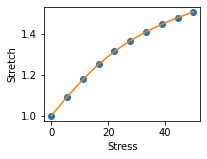

In [5]:
fig,ax = plt.subplots(1,1,figsize=(4*0.7,3*0.7))

ax.plot(applied_stress, observed_stretch,'o',label='Observed data')
ax.plot(applied_stress, simulate(params),'-',label='Fitted model')
ax.set_xlabel('Stress')
ax.set_ylabel('Stretch')
plt.show()

## Adding fiber direction 

For an anisotropic material, one has to specify the fiber direction. It could be included as a fitting parameter as shown below.

In [12]:
mat = pmt.MatModel('goh','nh')
sample = pmt.UniaxialExtension(mat, force_measure='cauchy')
params = sample.parameters
params['phi'] = pmt.Param(30,0,90) #Add fiber angle as a parameter
params.fix('L0')
params.fix('A0')
print(sample, params)

applied_stress = np.linspace(0,50,10)
observed_stretch = np.array([1., 1.09144422, 1.17650268, 1.25077441, 1.31313774, 1.36499585,
 1.40850493, 1.4455964, 1.4777529,  1.50606163])

def simulate(param_vary):
    pmt.specify_two_fibers(sample,param_vary['phi'],verbose=False)
    mod_stretch = sample.force_controlled(applied_stress, param_vary)
    return mod_stretch

param_fitter = pmt.ParamFitter(simulate,observed_stretch,params)

param_fitter.fit()

An object of type UniaxialExtensionwith stretch as input, cauchy as output, and the following material
Material model with 2 components:
Component1: GOH
Component2: NH
 ------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
L0                1.00        Yes         -           -           
A0                1.00        Yes         -           -           
k1_0              10.00       No          0.10        30.00       
k2_0              10.00       No          0.10        30.00       
k3_0              0.10        No          0.00        0.33        
mu_1              1.00        No          1.00e-04    1.00e+02    
phi               30.00       No          0.00        90.00       
------------------------------------------------------------------

Parameter fitting instance created with the following settings
------------------------------

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 2.220e-16  1.545e-03  1.479e-04 -9.979e-04 -8.545e-04
               -3.821e-06  7.319e-04  8.811e-04  3.014e-04 -9.714e-04]
           x: [ 1.072e+00  4.182e-01  4.898e-14  1.624e+01  1.712e-02]
        cost: 3.2410696722792836e-06
         jac: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
               [-1.507e-02 -6.118e-04 ... -4.462e-03  4.172e-07]
               ...
               [-9.765e-02 -1.468e-01 ... -7.910e-03  4.098e-06]
               [-1.011e-01 -1.735e-01 ... -7.228e-03  4.470e-06]]
        grad: [-3.516e-11 -4.143e-12  3.048e-06  2.088e-12  1.666e-11]
  optimality: 1.0171337805176332e-09
 active_mask: [ 0  0 -1  0  0]
        nfev: 212
        njev: 183

It took higher number of iterations, but fitting did work. When plotting the results, if we call the `simulate` function with `params`, we will get an error. This can solved by getting a normal dictionary from `params` and passing that instead.

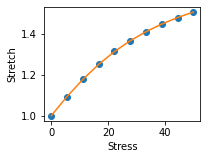

In [13]:
fig,ax = plt.subplots(1,1,figsize=(4*0.7,3*0.7))

ax.plot(applied_stress, observed_stretch,'o',label='Observed data')
ax.plot(applied_stress, simulate(params._val()),'-',label='Fitted model')
ax.set_xlabel('Stress')
ax.set_ylabel('Stretch')
plt.show()

## Combining multiple experiments

One can combine multiple experiments. For example, if two samples were taken at 90 degrees angles from the sample tissue and a uniaxial extension experiment was performed on each, we may want to have the same set of parameters fit both. This is demonstrated below.

In [33]:
#since the fiber directions are stored in material, it is better to create separate instances for the two
matC = pmt.MatModel('goh','nh')
matL = pmt.MatModel('goh','nh')

sample_C = pmt.UniaxialExtension(matC, force_measure='cauchy')
sample_L = pmt.UniaxialExtension(matL, force_measure='cauchy')
params = sample_L.parameters
#add fiber angle
params['phi'] = pmt.Param(30,0,90)

stretch_C = np.linspace(1,1.2,20)
stretch_L = np.linspace(1,1.5,20)
obs_stress_C = np.array([0.        ,  1.52571403,  3.07863692,  4.66062427,  6.27372501,
        7.92021013,  9.60260466, 11.32372343, 13.08671143, 14.89508926,
       16.75280476, 18.66429179, 20.63453731, 22.66915826, 24.77448991,
       26.95768758, 29.22684422, 31.59112643, 34.06093242, 36.64807567,])
obs_stress_L = np.array([0.        ,  3.15860501,  6.32132964,  9.49192622, 12.67378974,
       15.86999936, 19.08335432, 22.31640505, 25.57148019, 28.8507102 ,
       32.15604801, 35.48928713, 38.85207756, 42.24593993, 45.67227786,
       49.13238907, 52.62747512, 56.15865021, 59.72694895, 63.40018943])

observed_stresses = np.array([obs_stress_C,obs_stress_L])

def simulate_both(param_vary):
    pmt.specify_two_fibers(sample_C,param_vary['phi'],verbose=False)
    stress_C = sample_C.disp_controlled(stretch_C,param_vary)
    pmt.specify_two_fibers(sample_L,90-param_vary['phi'],verbose=False)
    stress_L = sample_L.disp_controlled(stretch_L,param_vary)
    return np.array([stress_C,stress_L]).flatten()



In [31]:
params.set('k1_0',20)
params.set('k2_0',5)
params.set('k3_0',0.2)
params.set('mu_1',40)
params.set('phi',10)

observed_stress = simulate_both(params._val())

In [32]:
observed_stress

array([ 0.        ,  1.52571403,  3.07863692,  4.66062427,  6.27372501,
        7.92021013,  9.60260466, 11.32372343, 13.08671143, 14.89508926,
       16.75280476, 18.66429179, 20.63453731, 22.66915826, 24.77448991,
       26.95768758, 29.22684422, 31.59112643, 34.06093242, 36.64807567,
        0.        ,  3.15860501,  6.32132964,  9.49192622, 12.67378974,
       15.86999936, 19.08335432, 22.31640505, 25.57148019, 28.8507102 ,
       32.15604801, 35.48928713, 38.85207756, 42.24593993, 45.67227786,
       49.13238907, 52.62747512, 56.15865021, 59.72694895, 63.40018943])

In [34]:
params.fix('L0')
params.fix('A0')
params.fix('k2_0',5)
param_fitter = pmt.ParamFitter(simulate_both,observed_stress.flatten(),params)

Parameter fitting instance created with the following settings
------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
L0                1.00        Yes         -           -           
A0                1.00        Yes         -           -           
k1_0              10.00       No          0.10        30.00       
k2_0              5.00        Yes         -           -           
k3_0              0.10        No          0.00        0.33        
mu_1              1.00        No          1.00e-04    1.00e+02    
phi               30.00       No          0.00        90.00       
------------------------------------------------------------------

4 parameters will be fitted.


In [35]:
param_fitter.fit()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4447e+04                                    7.34e+04    
       1              2         6.0074e+02      1.38e+04       2.82e+01       7.86e+03    
       2              3         2.6792e+01      5.74e+02       1.03e+01       6.72e+02    
       3              4         1.2815e+01      1.40e+01       5.54e+00       5.13e+02    
       4              5         2.9791e+00      9.84e+00       3.68e+00       1.85e+02    
       5              6         6.1167e-01      2.37e+00       2.31e+00       7.02e+01    
       6              7         1.7953e-01      4.32e-01       1.39e+00       2.05e+01    
       7              8         1.1631e-01      6.32e-02       7.68e-01       4.88e+00    
       8              9         1.0077e-01      1.55e-02       1.24e+00       1.47e+01    
       9             10         6.4888e-02      3.59e-02       3.30e-01       5.01e-01    

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 0.000e+00  5.795e-14 ... -7.105e-15  2.345e-13]
           x: [ 2.000e+01  2.000e-01  4.000e+01  1.000e+01]
        cost: 5.325728407563182e-25
         jac: [[ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
               [ 1.313e-02 -3.861e+00  3.158e-02 -4.021e-03]
               ...
               [ 0.000e+00  0.000e+00  1.493e+00  0.000e+00]
               [ 3.343e-03  3.988e+01  1.583e+00  1.050e-01]]
        grad: [-1.117e-12  3.067e-10 -9.828e-13  3.597e-13]
  optimality: 6.133447444857194e-11
 active_mask: [0 0 0 0]
        nfev: 69
        njev: 62